<a href="https://colab.research.google.com/github/nischal1234/DS7010final/blob/main/Text_DS7010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Text**

In [12]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

#################################
#x_train = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/s2e/audio_train.csv')
#x_test = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/s2e/audio_test.csv')
#################################
#df = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_train.csv')
#df = df.append(pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_test.csv'))
#display(df.head())
# Read train and test CSV files
train_df = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/t2e/text_test.csv')

# Concatenate train and test data
df = pd.concat([train_df, test_df], ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df.head())

                 wav_file  label  \
0     Ses02F_impro04_F012      2   
1  Ses03F_script02_1_M030      4   
2  Ses02F_script03_2_M015      2   
3  Ses02F_script02_2_M025      2   
4  Ses04M_script03_1_M021      1   

                                       transcription  
0                or they ll never talk to me again .  
1                                         for real ?  
2                                          nothing .  
3                      you wanna get married again ?  
4  let s savor the delight of the moment . come a...  


In [14]:
df.head()

,wav_file,label,transcription
0,Ses02F_impro04_F012,2,or they ll never talk to me again .
1,Ses03F_script02_1_M030,4,for real ?
2,Ses02F_script03_2_M015,2,nothing .
3,Ses02F_script02_2_M025,2,you wanna get married again ?
4,Ses04M_script03_1_M021,1,let s savor the delight of the moment . come a...


In [15]:
df.columns

Index(['wav_file', 'label', 'transcription'], dtype='object')

In [16]:
df.columns = ['wav_file','label', 'transcription']

In [17]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

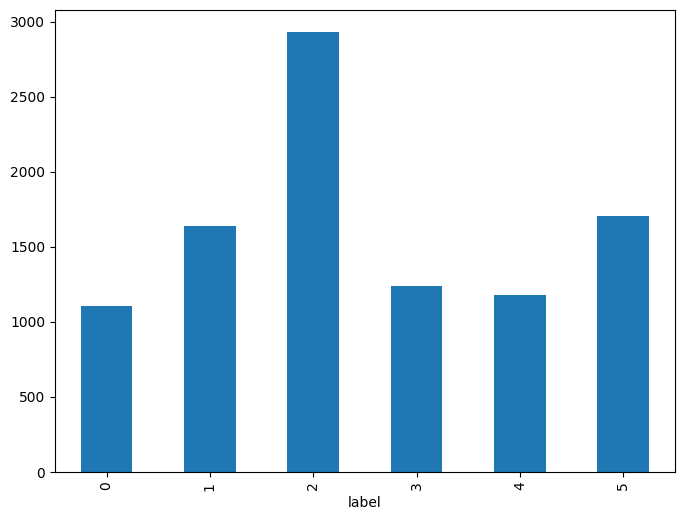

In [18]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [21]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

# **RF**

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **Logistic**

# **Extreme Gradient Boosting**

# **MLP**

# **ensemble learning**